# <b>Analysis of Austin Animal Center Shelter Outcome dataset</b>
Trying to model the outcomes of animals at the Austin Animal Center Shelter, using the [Austin Animal Center Shelter Income and Outcome dataset (Kaggle).](https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes) <br>

By Dar Mendelowitz

## <b>Imports</b>

In [88]:
# Data processing
import pandas as pd
import numpy as np

# Statistics
from scipy.stats import chi2_contingency

# Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine learning library
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap
import lime
import lime.lime_tabular

# Helper functions
from utils import print_animal_count, convert_to_years, replace_same_color
from utils import get_top_k, set_top_k_colors, sort_colors, set_top_k_breeds
from missing_values import print_animal_ids, count_missing_values, get_missing_animal_ids
from missing_values import get_existing_animal_ids_in_dataset, filter_null_values, update_column
from train_model import print_scores, get_scores, calculate_average_score, print_average_score
from train_model import fit_and_predict

import warnings
warnings.filterwarnings("ignore")

## <b>Loading the Austin Animal Center Shelter Outcome dataset</b>

In [89]:
# Loading the CSV dataset
df_in_out = pd.read_csv("./data/aac_intakes_outcomes.csv")
df_in = pd.read_csv("./data/aac_intakes.csv")
df_out = pd.read_csv("./data/aac_outcomes.csv")
dtf = df_out

# Defining the columns
cols = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color', 'date_of_birth', 'datetime',
        'monthyear', 'name', 'outcome_subtype', 'outcome_type', 'sex_upon_outcome']
dtf = dtf[cols]

In [90]:
dtf.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown


In [91]:
dtf.describe()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
count,80673,80681,80681,80681,80681,80681,80681,80681,56116,36893,80667,80679
unique,46,72877,5,2176,532,5956,66474,66474,14824,19,9,5
top,1 year,A721033,Dog,Domestic Shorthair Mix,Black/White,2015-09-01T00:00:00,2016-04-18T00:00:00,2016-04-18T00:00:00,Bella,Partner,Adoption,Neutered Male
freq,14911,13,45856,23821,8396,112,39,39,362,20082,34232,28702


In the table above, the number of animals in the shelter is 80681 (the count of unique 'animal_id' entries). However, not all columns contain 80681 values, as some entries are missing (NaN values).

For instance:

* The column 'age_upon_outcome' contains slightly fewer values, specifically 80673 entries.
* The 'name' column has significantly fewer entries, totaling 56116.
* In the 'outcome_subtype' column, there are even fewer entries, with only 36893 values present, which is less than half of the total number of animals in the shelter.
* Additionally, both the 'outcome_type' and 'sex_upon_outcome' columns have fewer entries.

Moreover, the number of unique 'animal_id' entries is less than the overall number of 'animal_id' entries (72877 < 80681). This discrepancy occurs because some animals have returned to the shelter. For example, a cat named Elsa (animal_id: A684460) was initially adopted (first outcome) at the age of 2 months. However, she was later returned to the shelter (sadly, her owner surrendered her at the age of 1 year, according to the aac_intakes_outcomes.csv table). After 25 days, Elsa was transferred to another shelter (second outcome).

***

### A first examination of the target feature - 'outcome_type':

A histogram of the target feature 'outcome_type':

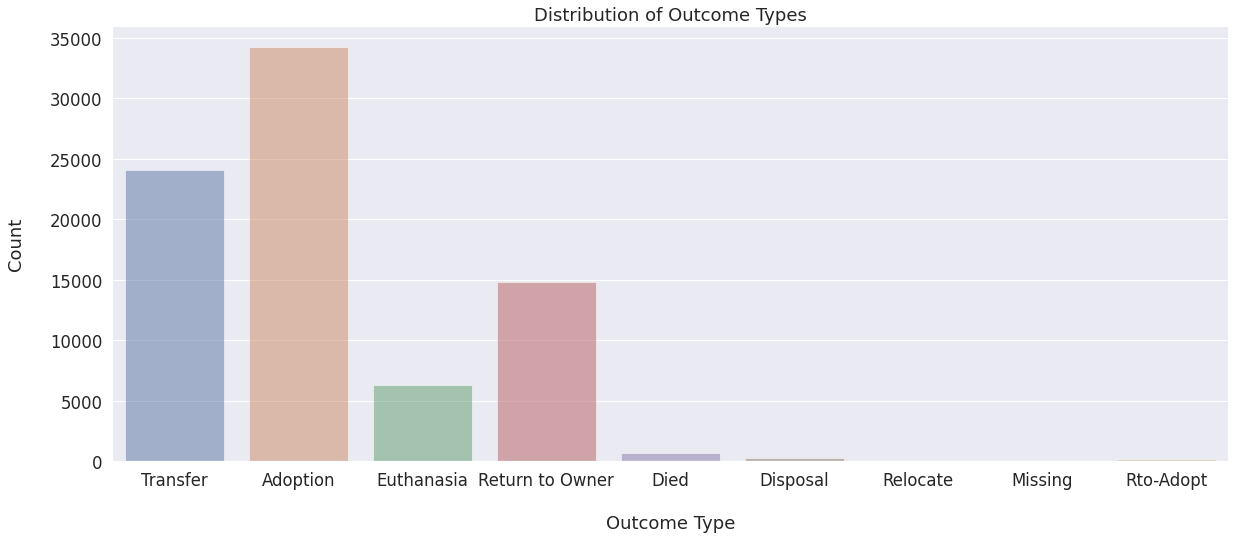

In [92]:
plt.figure(figsize=(20, 8))
sns.countplot(data=dtf, x='outcome_type', alpha=0.5)
plt.title('Distribution of Outcome Types')
plt.xlabel('Outcome Type', labelpad=25)
plt.ylabel('Count', labelpad=25)
plt.show()

We can see that most animals were adopted (almost 35,000 animals). Almost 25,000 animals were transfered (to another shelter), about 15,000 were returned to their original owners, a little bit more than 5000 were euthanized. A small number of animals have died, an even smaller number were disposed, relocated, missing or Rto-Adopted.

Overall, most animals either were adopted, transfered, returned to owner or euthanized.

In [93]:
outcome_list = ['Return to Owner', 'Transfer', 'Adoption', 'Euthanasia', 'Died', 'Rto-Adopt', 'Missing',
                'Disposal', 'Relocate']

***

## <b>Data Pre-Processing</b>

***Feature engineering and data cleansing.***

### <b>Outcome Type Distribution</b>

Counting the number of outcome types:

In [94]:
print_animal_count(dtf, 'outcome_type')

      outcome_type  count  percentage
0         Adoption  34232   42.436188
8         Transfer  24050   29.813926
6  Return to Owner  14851   18.410255
3       Euthanasia   6289    7.796249
1             Died    699    0.866525
2         Disposal    304    0.376858
7        Rto-Adopt    179    0.221900
4          Missing     47    0.058264
5         Relocate     16    0.019835


According to the Austin Animal Center Shelter website, 'Rto-Adopt' is when an animal is returned to their owner <font color='#5fc7fa'>(Rto=return to owner)</font>, usually after it was lost, taken in the shelter as a stray and the shelter was able to locate a chip that led to the owner. Since there aren't a lot of samples of the 'Rto-Adopt' instance and it's the same as 'Return to Owner outcome', I've decided to combine both outcome types:

In [95]:
# Replace 'Rto-Adopt' with 'Return to Owner' in the 'outcome_type' column
dtf['outcome_type'] = dtf['outcome_type'].replace('Rto-Adopt', 'Return to Owner')

Removing all instances with less than 1% samples in the dataset - 'Died', 'Disposal', 'Missing' and 'Relocate':

In [96]:
dtf = dtf[(dtf['outcome_type'] != 'Died') & 
          (dtf['outcome_type'] != 'Disposal') & 
          (dtf['outcome_type'] != 'Missing') & 
          (dtf['outcome_type'] != 'Relocate')]

After change:

In [97]:
print_animal_count(dtf, 'outcome_type')

      outcome_type  count  percentage
0         Adoption  34232   43.004485
3         Transfer  24050   30.213188
2  Return to Owner  15030   18.881672
1       Euthanasia   6289    7.900655


The model will predict one of these four possible outcome types as the outcome of an animal listed in the dataset.

***

### <b>Outcome Subtype Distribution</b>

Counting the number of outcome subtype:

In [98]:
print_animal_count(dtf, 'outcome_subtype')

        outcome_subtype  count  percentage
8               Partner  20082   55.403206
5                Foster   5714   15.764063
10                 SCRP   3211    8.858664
12            Suffering   2563    7.070930
9           Rabies Risk   2546    7.024030
11                  Snr    755    2.082931
0            Aggressive    508    1.401495
7               Offsite    367    1.012498
6               Medical    268    0.739372
3              Behavior    142    0.391757
1                At Vet     37    0.102077
13             Underage     28    0.077248
4   Court/Investigation     23    0.063454
2                  Barn      3    0.008277


Removing all instances with less than 1% samples in the dataset - 'Medical', 'Behavior', 'At Vet', 'Underage', 'Court/Investigation' and 'Barn':

In [99]:
dtf = dtf[(dtf['outcome_subtype'] != 'Medical') & 
          (dtf['outcome_subtype'] != 'Behavior') & 
          (dtf['outcome_subtype'] != 'At Vet') & 
          (dtf['outcome_subtype'] != 'Underage') & 
          (dtf['outcome_subtype'] != 'Court/Investigation') &
          (dtf['outcome_subtype'] != 'Barn')]

***

### <b>Animal Type Distribution</b>

Counting the number of each animal type:

In [100]:
print_animal_count(dtf, 'animal_type')

  animal_type  count  percentage
2         Dog  45444   57.441161
1         Cat  29493   37.279116
4       Other   3869    4.890411
0        Bird    298    0.376672
3   Livestock     10    0.012640


We can see that the two most common animals in the shelter are cats and dogs (57.38% of animals in the shelter are dogs and 37.31% are cats).
Other kind of animals (including a variety of different animals - small mammal such as bats, racoons and rabbits, wild animals such as bobcats and deers, and also reptiles and arachnids) make just 4.9% of animals in the shelter. Birds and livestock contribute less than 1%. For simplicity, I've opted to categorize birds and livestock under the 'Other' classification.

Combining birds and livestock under the 'Other' animal type classification:

In [101]:
# Replace 'Livestock' and 'Bird' with 'Other' in the 'animal_type' column
dtf['animal_type'] = dtf['animal_type'].replace(['Livestock', 'Bird'], 'Other')

Counting the number of animals:

In [102]:
print_animal_count(dtf, 'animal_type')

  animal_type  count  percentage
1         Dog  45444   57.441161
0         Cat  29493   37.279116
2       Other   4177    5.279723


Now there are only three animal groups in the dataset - cats, dogs and other.

***

### <b>Missing values</b>

How many values are missing?

In [103]:
dtf.isnull().sum()

age_upon_outcome        8
animal_id               0
animal_type             0
breed                   0
color                   0
date_of_birth           0
datetime                0
monthyear               0
name                23513
outcome_subtype     43368
outcome_type           14
sex_upon_outcome        2
dtype: int64

There are 8 missing values in the 'age_upon_outcome' column, 14 in the 'outcome_type' column, and 2 in the 'sex_upon_outcome' column, all of which can be addressed relatively easily (for instance, some missing data may be found in the 'in_out_df' dataset). However, the primary challenge lies in managing the extensive amount of missing data in the 'name' and 'outcome_subtype' columns.

Some missing values could potentially be recovered from the aac_intakes_outcomes.csv dataset and the aac_intakes.csv dataset. While columns such as 'age_upon_outcome', 'outcome_type', and 'sex_upon_outcome' contain only a few missing values, it is worth searching for any existing missing data that might be present in the other datasets (besides searching for missing data of the two major sparse columns - 'name' and 'outcome_subtype').

***

#### <b>Missing values of 'age_upon_outcome'</b>

Checking if the missing 'animal_id' values exist in <font color='#fc0335'><b>df_in_out</b></font> (using the aac_intakes_outcomes.csv dataset):

In [104]:
column_name = 'age_upon_outcome'
df_id = 'animal_id_outcome'

# Find all 'animal_id' of rows with None values in the 'age_upon_outcome' column
missing_animal_ids_age = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_age)

# Selecting the existing 'animal_id' values based on existence in the filtered df_in_out
existing_animal_id_age = get_existing_animal_ids_in_dataset(df_in_out, column_name,
                                                        missing_animal_ids_age, df_id)
print_animal_ids(column_name, existing_animal_id_age, 'df_in_out')

Animal IDs with missing values in 'age_upon_outcome' column:
71248    A737705
80344    A768766
80541    A768782
80544    A769181
80548    A769209
80608    A769277
80628    A768281
80664    A769101
Name: animal_id, dtype: object

Animal IDs with missing values in 'age_upon_outcome' column that exist in df_in_out dataset:
80541    A768782
Name: animal_id, dtype: object



Retrieving the missing value, updating the dataset and removing missing values:

In [105]:
# Retrieving the missing value and updating the 'age_upon_outcome' column with the new value
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_age, df_id)

# Geting all 'animal_id' of rows with None values in the 'age_upon_outcome' column
missing_animal_ids_age = get_missing_animal_ids(dtf, column_name)

# Filtering dtf to exclude rows with 'animal_id' values in missing_animal_ids_age
dtf = dtf[~dtf['animal_id'].isin(missing_animal_ids_age)]

***

#### <b>Missing values of 'outcome_type'</b>

Checking if the missing 'animal_id' values exist in <font color='#fc0335'><b>df_in_out</b></font> (using the aac_intakes_outcomes.csv dataset):

In [106]:
column_name = 'outcome_type'
df_id = 'animal_id_outcome'

# Find all 'animal_id' of rows with None values in the 'outcome_type' column
missing_animal_ids_outcome = get_missing_animal_ids(dtf, column_name)
print_animal_ids(column_name, missing_animal_ids_outcome)

# Selecting the existing 'animal_id' values based on existence in the filtered df_in_out
existing_animal_id_outcome = get_existing_animal_ids_in_dataset(df_in_out, column_name,
                                                            missing_animal_ids_outcome, df_id)

# Filtering out any null values
existing_animal_id_outcome = filter_null_values(df_in_out, column_name, existing_animal_id_outcome,
                                                                                    outcome_list, df_id)
print_animal_ids(column_name, existing_animal_id_outcome, 'df_in_out')

Animal IDs with missing values in 'outcome_type' column:
8056     A671017
9951     A674209
9975     A679066
12758    A686025
30969    A744013
55432    A718046
64762    A737930
67535    A755711
72899    A755715
75152    A755716
80590    A769260
80598    A769266
Name: animal_id, dtype: object

Animal IDs with missing values in 'outcome_type' column that exist in df_in_out dataset:
64762    A737930
67535    A755711
72899    A755715
75152    A755716
Name: animal_id, dtype: object



Retrieving the missing values, updating the dataset and removing missing values:

In [107]:
# Retrieving the missing values and updating the 'outcome_type' column with the new values
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_outcome, df_id)

# Get all 'animal_id' of rows with None values in the 'outcome_type' column
missing_animal_ids_outcome = get_missing_animal_ids(dtf, column_name)

# Filter dtf to exclude rows with 'animal_id' values in missing_animal_ids_age
dtf = dtf[~dtf['animal_id'].isin(missing_animal_ids_outcome)]

***

#### <b>Missing values of 'sex_upon_outcome'</b>

Checking if the missing 'animal_id' values exist in <font color='#fc0335'><b>df_in_out</b></font> (using the aac_intakes_outcomes.csv dataset):

In [108]:
column_name = 'sex_upon_outcome'
df_id = 'animal_id_outcome'

# Find all 'animal_id' of rows with None values in the 'sex_upon_outcome' column
missing_animal_ids_outcome_sex = get_missing_animal_ids(dtf, column_name)
count_missing_values(column_name, missing_animal_ids_outcome_sex)

# Selecting the existing 'animal_id' values from missing_animal_ids_outcome_sex
# based on existence in the filtered df_in_out
existing_animal_id_outcome_sex = get_existing_animal_ids_in_dataset(df_in_out, column_name,
                                                        missing_animal_ids_outcome_sex, df_id)
count_missing_values(column_name, existing_animal_id_outcome_sex, 'df_in_out')

Number of animal IDs with missing values in 'sex_upon_outcome' column is 1.
Number of animal IDs with missing values in 'sex_upon_outcome' column that exist in df_in_out dataset is 0.



There is no existing data in df_in_out dataset (that matches the missing value in the 'sex_upon_outcome' column). The missing row will just be removed from the dtf dataset:

In [109]:
# Finding the 'animal_id' that doesn't exist in df_in_out
missing_animal_id_outcome_sex = missing_animal_ids_outcome_sex.iloc[0]

# Filter dtf to exclude the row with the 'animal_id' value of missing_animal_id_outcome_sex
dtf = dtf.drop(dtf[dtf['animal_id'] == missing_animal_id_outcome_sex].index)

***

#### <b>Missing values of 'outcome_subtype'</b>

Checking if the missing 'animal_id' values exist in <font color='#fc0335'><b>df_in_out</b></font> (using the aac_intakes_outcomes.csv dataset):

In [110]:
column_name = 'outcome_subtype'
df_id = 'animal_id_outcome'

sub_outcome_list = dtf['outcome_subtype'].dropna().unique()

# Find all 'animal_id' of rows with None values in the 'outcome_subtype' column
missing_animal_ids_sub = get_missing_animal_ids(dtf, column_name)
count_missing_values(column_name, missing_animal_ids_sub)

# Selecting the existing 'animal_id' values based on existence in the filtered df_in_out
existing_animal_id_sub = get_existing_animal_ids_in_dataset(df_in_out, column_name,
                                                            missing_animal_ids_sub, df_id)

# Filtering out any null values
existing_animal_id_sub = filter_null_values(df_in_out, column_name, existing_animal_id_sub,
                                                                        sub_outcome_list, df_id)
count_missing_values(column_name, existing_animal_id_sub, 'df_in_out')

Number of animal IDs with missing values in 'outcome_subtype' column is 43357.
Number of animal IDs with missing values in 'outcome_subtype' column that exist in df_in_out dataset is 1784.



<br>The count of animal IDs with missing values in the 'outcome_subtype' column is 43,357. Among these, 1,784 IDs also exist in the 'df_in_out' dataset, indicating a smaller yet notable subset.

Retrieving the missing values and updating the dataset, while defining a default outcome subtype for missing values:

---------------------Takes ~1-2minutes - add skip option

In [111]:
# Retrieving the missing values and updating the 'outcome_subtype' column with the new values
dtf = update_column(dtf, df_in_out, column_name, existing_animal_id_sub, df_id)

# Find all 'animal_id' of rows with None values in the 'outcome_subtype' column
missing_animal_ids_sub = get_missing_animal_ids(dtf, column_name)

# Define a default value for missing values in 'outcome_subtype' column
default_subtype = "Unknown"

# Set the default value for 'outcome_subtype' where 'animal_id' matches any element in missing_animal_ids_sub
dtf.loc[dtf['animal_id'].isin(missing_animal_ids_sub), column_name] = default_subtype

I refrained from simply duplicating the values from the 'outcome_type' column and substituting them with missing values in the 'outcome_subtype' column, respectively. My rationale behind this decision was to avoid <b>artificially inflating</b> the importance of those instances. By replicating the same value twice within a single row for certain entries in the dataset, it could potentially <b>skew</b> the significance of those instances compared to others. I opted to assign a default value of 'Unknown' instead.

***

#### <b>Missing values of 'name'</b>

Checking if the missing 'animal_id' values exist in <font color='#fc0335'><b>df_in</b></font> (using the aac_intakes.csv dataset):

In [112]:
column_name = 'name'
df_id = 'animal_id'

# Find all 'animal_id' of rows with None values in the 'name' column
missing_animal_ids_name = get_missing_animal_ids(dtf, column_name)
count_missing_values(column_name, missing_animal_ids_name)

# Selecting the existing 'animal_id' values based on existence in the filtered df_in
existing_animal_id_name = get_existing_animal_ids_in_dataset(df_in, column_name,
                                                        missing_animal_ids_name, df_id)
count_missing_values(column_name, existing_animal_id_name, 'df_in')

Number of animal IDs with missing values in 'name' column is 23501.
Number of animal IDs with missing values in 'name' column that exist in df_in dataset is 0.



There is no existing data in df_in dataset (that matches the missing values in the 'name' column).

Animals without a name will be given a default name. The reason that I chose to give them a default name (rather than just deleting the rows with the missing values) is that there might be a <b>reason</b> why these animals weren't given a name, and the fact that they don't have a name <b>might predict</b> their outcome. For example, rabid animals that are being euthanized aren't being named.

<b>Missing values in the <font color='#fc0335'>df_in</font> dataset:</b>

In [113]:
df_in['name'].isnull().sum()

24584

We can see that the number of missing names in the df_in dataset is similar to the number of missing names in the dtf dataset:
<br>24584 in df_in vs. 24553/23501 in dtf before/after eliminating instances in the 'outcome_type'/'outcome_subtype' columns.

Perhaps Some of the animals were just taken in the shelter and nothing changed since that, so they don't have any outcome recorded, and therefore don't appear in the outcome dataset dtf, which can explains the difference in the numbers.
<br>
<br>
<br>

Some animals in the shelter have a name, and some don't. The name itself might not predict the outcome of the animal, but the fact that the animal has a name does. For this reason I've decided to convert the 'name' column to a 'binary' column ('Yes' or 'No') if an animal has a name or if it doesn't:

In [114]:
# Rename the column 'name' to 'is_named'
dtf.rename(columns={'name': 'is_named'}, inplace=True)

# Define a default value for the 'is_named' column (that will be replaced)
default_name = "Unknown"

# Set the default value for 'is_named' where 'animal_id' matches any element in missing_animal_ids_name
dtf.loc[dtf['animal_id'].isin(missing_animal_ids_name), 'is_named'] = default_name

dtf['is_named'] = np.where(dtf['is_named'].str.contains('Unknown'), 'No', 'Yes')

***

#### Missing values - Conclusion:

How many values are missing now?

In [115]:
dtf.isnull().sum()

age_upon_outcome    0
animal_id           0
animal_type         0
breed               0
color               0
date_of_birth       0
datetime            0
monthyear           0
is_named            0
outcome_subtype     0
outcome_type        0
sex_upon_outcome    0
dtype: int64

Now there are no missing values in the dataset.

***

### <b>Additional Feature Engineering</b>

#### <b>Converting 'age_upon_outcome' column to a numeric column:</b>

In [116]:
# Apply the function convert_to_years to the 'age_upon_outcome' column
dtf['age_upon_outcome'] = dtf['age_upon_outcome'].apply(convert_to_years)

***

#### <b>Deleting 'date_of_birth' column:</b>

Each animal's age is provided in the dataset. Given the variability in the accuracy of birth dates, as indicated by the Austin Animal Center Shelter website, it's more practical to represent an animal's age in a numeric format rather than relying on a datetime format to denote the day of birth. This approach accommodates instances where birth dates are uncertain or assessed, ensuring greater consistency and convenience for analysis.

In [117]:
# Removing 'date_of_birth' column from dtf
dtf = dtf.drop('date_of_birth', axis=1)

***

#### <b>Deleteing 'monthyear' column:</b>

In [118]:
datetime = dtf['datetime']
monthyear = dtf['monthyear']

# Check if the two columns are equal
are_equal = (datetime == monthyear).all()

# Print the result
if are_equal:
    print("The columns 'datetime' and 'monthyear' are equal")
else:
    print("Not equal")

The columns 'datetime' and 'monthyear' are equal


Since 'datetime' and 'monthyear' are two equal columns, I've decided to delete one of them - 'monthyear':

In [119]:
# Remove column 'monthyear'
dtf = dtf.drop('monthyear', axis=1)

***

#### <b>Converting 'datatime' column into numeric columns:</b>

Replacing the column 'datetime' into five columns - 'outcome_year' (year of outcome), 'outcome_month' (month of outcome) 'outcome_date' (day in the month of outcome), 'outcome_weekday' (day in the week of outcome),  and 'outcome_hour' (hour of outcome):

In [120]:
# Converting 'outcome_date' into datetime
dtf['datetime'] = pd.to_datetime(dtf['datetime'])

dtf['outcome_year'] = dtf['datetime'].dt.year
dtf['outcome_month'] = dtf['datetime'].dt.month
dtf['outcome_date'] = dtf['datetime'].dt.daysinmonth
dtf['outcome_weekday'] = dtf['datetime'].dt.dayofweek
dtf['outcome_hour'] = dtf['datetime'].dt.hour

# Rearranging the columns in dtf
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color', 'outcome_year',
                'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named',
                'outcome_subtype', 'outcome_type', 'sex_upon_outcome']
dtf = dtf[column_order]

***

#### <b>Spliting 'sex_upon_outcome' column:</b>

<font color='#839fd4'>For this part I've used the code from the Extraction and Feature Engineering of Animal Austin Center's Shelter Outcomes Dataset using Requests and Pandas written by Aaron Schlegel (https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html).</font>

Transforming the column 'sex_upon_outcome' into two columns - 'sex' (containing the sex of the animal) and 'spayed_neutered' (containing if an animal is spayed/neutered):

In [121]:
# Create a new column 'sex' based on the 'sex_upon_outcome' column
dtf['sex'] = np.where(dtf['sex_upon_outcome'].str.contains('Male'), 'Male', 
                              np.where(dtf['sex_upon_outcome'].str.contains('Unknown'), 'Unknown', 'Female'))

# Create a new column 'Spay/Neuter' based on the 'sex_upon_outcome' column
dtf['spayed_neutered'] = np.where(dtf['sex_upon_outcome'].str.contains('Intact'), 'No', 
                              np.where(dtf['sex_upon_outcome'].str.contains('Unknown'), 'Unknown', 'Yes'))

# Deleting the 'sex_upon_outcome' column
dtf = dtf.drop(columns=['sex_upon_outcome'])

In the 'sex' column:<br>
'Male' assigned as 'Male', 'Female' assigned as 'Female', and 'Unknown' assigned as 'Unknown'.

In the 'spayed_neutered' column:<br>
'Intact' assigned as 'No', 'Spay/Neuter' assigned as 'Yes', and 'Unknown' assigned as 'Unknown'.

***

#### <b>Fixing 'color' column:</b>

'Orange' cats are gingers, and all ginger cats are tabbies. This is why I'm changing all values of 'Orange Tabby' or 'Orange' into 'Ginger':

In [153]:
# Filtering rows where 'animal_type' is 'Cat' and 'color' contains 'Orange'
cats = dtf[dtf['animal_type'] == 'Cat']
orange_cats = cats[cats['color'].str.contains('Orange')]

# Replacing 'Orange Tabby' or 'Orange' with 'Ginger' in the 'color' column
orange_cats['color'] = orange_cats['color'].str.replace('Orange Tabby', 'Ginger')
orange_cats['color'] = orange_cats['color'].str.replace('Orange', 'Ginger')

# Updating the changes in the original DataFrame
dtf.update(orange_cats)

In [242]:
# Custom function to check and replace values
def replace_same_color(x):
    parts = x.split('/')
    if len(parts) == 2 and parts[0] == parts[1]:
        return parts[0]
    return x

Replacing every value in the 'color' column that contains a string separated by '/', and both parts of the string are the same (for example, 'Black/Black' will be replaced with 'Black'):

In [243]:
# Appling the function replace_same_color to the 'color' column
dtf['color'] = dtf['color'].apply(replace_same_color)

***

In [244]:
df = dtf.copy()

***

#### <b>Color Distribution</b>

In [245]:
print(f"Number of different colors in the 'color' column: {len(df['color'].value_counts())}")

Number of different colors in the 'color' column: 507


The 'color' column contains 507 unique values, which could potentially make the model overly complex due to the large number of parameters. To mitigate this complexity, I'll aim to include only the most prevalent values from the column, thereby simplifying the model.

In [247]:
k = 10

Top 10 cat colors:

In [248]:
top_k_cat_colors = pd.DataFrame(get_top_k(df, 'color', 'Cat', k))
top_k_cat_colors.head(k)

,count,percentage
Brown Tabby,4457,15.113598
Black,3898,13.218040
Black/White,2784,9.440488
Brown Tabby/White,2345,7.951848
Ginger,2245,7.612750
Tortie,1361,4.615124
Calico,1324,4.489658
Ginger/White,1180,4.001356
Blue Tabby,1135,3.848762
Blue,1056,3.580875


The predominant colors of cats typically include brown tabby, black, black and white, brown and white tabby, or ginger. I've decided to keep all instances of the top-30 coat colors, while any other colors will be substituted with a default value:

In [249]:
df = set_top_k_colors(df, 'Cat', 'Other Cat Color', 30)

Top 10 dog colors:

In [250]:
top_k_dog_colors = pd.DataFrame(get_top_k(df, 'color', 'Dog', k))
top_k_dog_colors.head(k)

,count,percentage
Black/White,5230,11.509936
Black,2569,5.653734
Brown/White,2478,5.453465
Tan/White,2447,5.385242
White,2424,5.334624
Tan,2038,4.485134
Tricolor,1970,4.335483
Brown,1857,4.086798
Black/Tan,1856,4.084597
White/Black,1560,3.433174


The most common colors for dogs often include black and white, black, brown and white, tan and white, or white. I've decided to keep all instances of the top-30 coat colors, while any other colors will be substituted with a default value:

In [251]:
df = set_top_k_colors(df, 'Dog', 'Other Dog Color', 30)

Top 10 colors of other animals:

In [252]:
top_k_other_colors = pd.DataFrame(get_top_k(df, 'color', 'Other', k))
top_k_other_colors.head(k)

,count,percentage
Brown,1541,36.972169
Black,279,6.693858
Brown/Black,265,6.357965
Black/White,257,6.166027
Gray/Black,228,5.470250
Gray,199,4.774472
Black/Brown,149,3.574856
Black/Gray,135,3.238964
Red,134,3.214971
White,115,2.759117


The predominant colors for other animals typically include brown, black and white, black, gray and black, or black and white I've decided to keep all instances of the top-30 colors, while any other colors will be substituted with a default value:

In [253]:
df = set_top_k_colors(df, 'Other', 'Other Color', 30)

Counting the number of unique colors:

In [254]:
print(f"Number of different colors in the 'color' column: {len(df['color'].value_counts())}")

Number of different colors in the 'color' column: 70


The 'color' column now contains only 70 unique values, down from 507. This reduction is substantial and could potentially enhance the model's performance.

***

#### <b>Spliting 'color' column:</b>

In [255]:
# Split values in the 'color' column based on '/'
split_colors = df['color'].str.split('/', expand=True)

# Apply the sorting function along the rows
# A value of two colors will be split into two values and then sorted alphabetically
sorted_colors = split_colors.apply(sort_colors, axis=1)

# Assign the first and second element to 'color1' and 'color2' respectively
df['color1'] = sorted_colors.apply(lambda x: x[0])
df['color2'] = sorted_colors.apply(lambda x: x[1])

# Replace missing values in 'color2' with a default value
default_color = 'No Color'
df['color2'].fillna(default_color, inplace=True)

In [262]:
# Drop the original 'color' column if needed
df.drop(columns=['color'], inplace=True)

# Rearrange the columns
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'color1', 'color2',
                'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour',
                'is_named', 'outcome_subtype', 'outcome_type', 'sex', 'spayed_neutered']
df = df[column_order]

In [263]:
print(f"Number of different colors in the 'color1' column: {len(df['color1'].value_counts())}")
print(f"Number of different colors in the 'color2' column: {len(df['color2'].value_counts())}")

Number of different colors in the 'color1' column: 36
Number of different colors in the 'color2' column: 8


***

#### <b>Fixing 'breed' column:</b>

<font color='#839fd4'>For this part I've used the code from the Extraction and Feature Engineering of Animal Austin Center's Shelter Outcomes Dataset using Requests and Pandas written by Aaron Schlegel (https://aaronschlegel.me/extraction-feature-engineering-aac-data-requests-pandas.html).</font>

Adding a new column 'mixed_breed' (to identify if an animal is mixed breed or not) and correcting some breeds:

In [264]:
# Create a new column 'mixed_breed' based on the 'breed' column
df['mixed_breed'] = np.where(df['breed'].str.contains('Mix'), 'Yes', 'No')

# Rearrange the columns
column_order = ['age_upon_outcome', 'animal_id', 'animal_type', 'breed', 'mixed_breed', 'color1', 'color2',
                'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour', 'is_named',
                'outcome_subtype', 'outcome_type', 'sex', 'spayed_neutered']
df = df[column_order]

# Removing the word 'Mix' from the breeds and removing blank spaces
df['breed'] = df['breed'].str.replace('Mix', '').str.strip()

# Replacing 'Medium Hair' with 'Mediumhair'
df['breed'] = df['breed'].str.replace('Medium Hair', 'Mediumhair')

# Replacing 'Chihuahua Shorthair' and 'Chihuahua Longhair' with 'Chihuahua'
df['breed'].replace({'Chihuahua Shorthair': 'Chihuahua', 'Chihuahua Longhair': 'Chihuahua'}, inplace=True)

# Replace breeds associated with rodents with 'Rodent' in the 'breed' column
rodents = ['Guinea Pig', 'Squirrel', 'Rat', 'Hamster']
df['breed'].replace(rodents, 'Rodent', inplace=True)

# Replacing 'Rabbit Sh' and 'Rabbit Lh' with 'Rabbit'
df['breed'].replace({'Rabbit Sh': 'Rabbit', 'Rabbit Lh': 'Rabbit'}, inplace=True)

In the 'sex' column:<br>
'Mix' assigned as 'Yes', otherwise assigned as 'No'.

In the 'breed' column:<br>
The word 'Mix' was removed from all the different breeds (irrelevant to the type of the breed). Also, 'Medium Hair' was replaceed with a single word of 'Mediumhair' (just like 'Shorthair' and 'Longhair' are single words). 'Chihuahua Shorthair' and 'Chihuahua Longhair' were replaced with 'Chihuahua'. Any kind of common rodent was replaced with the value of 'Rodent'. 'Rabbit Sh' and 'Rabbit Lh' were replaced with 'Rabbit'.

***

#### <b>Breed Distribution</b>

In [265]:
print(f"Number of different breeds in the 'breed' column: {len(df['breed'].value_counts())}")

Number of different breeds in the 'breed' column: 1944


The 'breed' column contains 1944 unique values, which could potentially make the model overly complex due to the large number of parameters. To mitigate this complexity, I'll aim to include only the most prevalent values from the column, thereby simplifying the model.

In [267]:
k = 10

Top 10 cat breeds:

In [268]:
top_k_cat_breeds = pd.DataFrame(get_top_k(df, 'breed', 'Cat', k))
top_k_cat_breeds.head(k)

,count,percentage
Domestic Shorthair,23783,80.647677
Domestic Mediumhair,2455,8.324856
Domestic Longhair,1279,4.337063
Siamese,1051,3.563920
American Shorthair,207,0.701933
Snowshoe,156,0.528993
Maine Coon,119,0.403527
Manx,79,0.267887
Russian Blue,71,0.240760
Himalayan,39,0.132248


Most cats are domestic shorthairs, domestic mediumhairs, domestic longhairs or siameses. Other types of cat breeds are less than 1%, and so I've decided to keep all instances that have more than 1% samples in the dataset as-is, and any other breed will be replaced with a default value:

In [269]:
df = set_top_k_breeds(df, 'Cat', 'Other Cat Breed', 4)

Top 30 dog breeds:

In [270]:
top_k_dog_breeds = pd.DataFrame(get_top_k(df, 'breed', 'Dog', 30))
top_k_dog_breeds.head(30)

,count,percentage
Pit Bull,6480,14.260877
Chihuahua,5419,11.925879
Labrador Retriever,5056,11.127005
German Shepherd,2191,4.821849
Australian Cattle Dog,1183,2.603490
Dachshund,915,2.013689
Boxer,773,1.701182
Miniature Poodle,716,1.575739
Border Collie,708,1.558133
Siberian Husky,558,1.228020


Most dogs are pit bulls, labradors, chihuahuas, german shepherds and australian cattle dogs. I've decides to keep all the instances above of breeds of dogs, and any other breed will be replaced with a default value:

In [271]:
df = set_top_k_breeds(df, 'Dog', 'Other Dog Breed', 30)

Top 20 breeds of other animals:

In [272]:
top_k_other_breeds = pd.DataFrame(get_top_k(df, 'breed', 'Other', 20))
top_k_other_breeds.head(20)

,count,percentage
Bat,1933,46.377159
Raccoon,584,14.011516
Rodent,341,8.181382
Rabbit,317,7.605566
Opossum,201,4.822457
Chicken,121,2.903071
Skunk,115,2.759117
Fox,50,1.199616
Californian,33,0.791747
Ferret,31,0.743762


Most of the other animals are bats, raccoons, rabbits, opoussums and guinea pigs. Other types of breeds are less than 150 samples, and so I've decided to keep all instances that have above than 150 samples in the dataset as-is, and any other breed will be replaced with a default value:

In [273]:
df = set_top_k_breeds(df, 'Other', 'Other Breed', 5)

Counting the number of unique colors:

In [274]:
print(f"Number of different breeds in the 'breed' column: {len(df['breed'].value_counts())}")

Number of different breeds in the 'breed' column: 42


The 'breed' column now contains only 42 unique values, down from 1944. This reduction is substantial and could potentially enhance the model's performance.

***

## <b>Goodness Of Fit</b>

### <b>Chi-Squared Test for Feature Selection</b>

In [275]:
# Columns for analysis
columns_of_interest = ['age_upon_outcome', 'animal_type', 'breed', 'mixed_breed', 'color1', 'color2',
                    'outcome_year', 'outcome_month', 'outcome_date', 'outcome_weekday', 'outcome_hour',
                    'is_named', 'outcome_subtype', 'sex', 'spayed_neutered']

In [276]:
# Create a list to store the results
chi_results = []

# Loop through each column and perform chi-square test
for column in columns_of_interest:
    contingency_table = pd.crosstab(df[column], df['outcome_type'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi_results.append({'column' : column, 'score' : chi2, 'p_val' : p})

In [277]:
chi_df = pd.DataFrame(chi_results).sort_values('p_val', ascending=False)
chi_df.head(15)

,column,score,p_val
8,outcome_date,233.537489,2.958542e-45
6,outcome_year,718.212960,2.436498e-143
3,mixed_breed,992.785104,6.610866e-215
0,age_upon_outcome,26984.718729,0.000000e+00
1,animal_type,38563.415110,0.000000e+00
2,breed,47844.492538,0.000000e+00
4,color1,11334.736806,0.000000e+00
5,color2,6468.840338,0.000000e+00
7,outcome_month,1824.259798,0.000000e+00
9,outcome_weekday,2582.196131,0.000000e+00


It looks like all of the columns have extremely low p-values, indicating that there is strong evidence to reject the null hypothesis that there is no association between each of these columns and the outcome_type. In other words, the values in each column are not distributed randomly across different outcome types; instead, they are related to or influenced by the outcome type of the animal. This association indicates that each column contains information that can help predict or explain the outcome type of animal outcomes in the dataset. Therefore, these columns are potentially important predictors or factors influencing the outcome type.

***

### <b>Examining Correlations to the target feature</b>

In [278]:
# Defining columns to encode
columns_to_encode = ['outcome_type', 'animal_type', 'mixed_breed', 'is_named', 'sex', 'spayed_neutered']

# Encoding columns using one-hot encoding
dtf_encoded = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

# Defining outcome type columns
outcome_type_columns = [col for col in dtf_encoded.columns if 'outcome_type' in col]

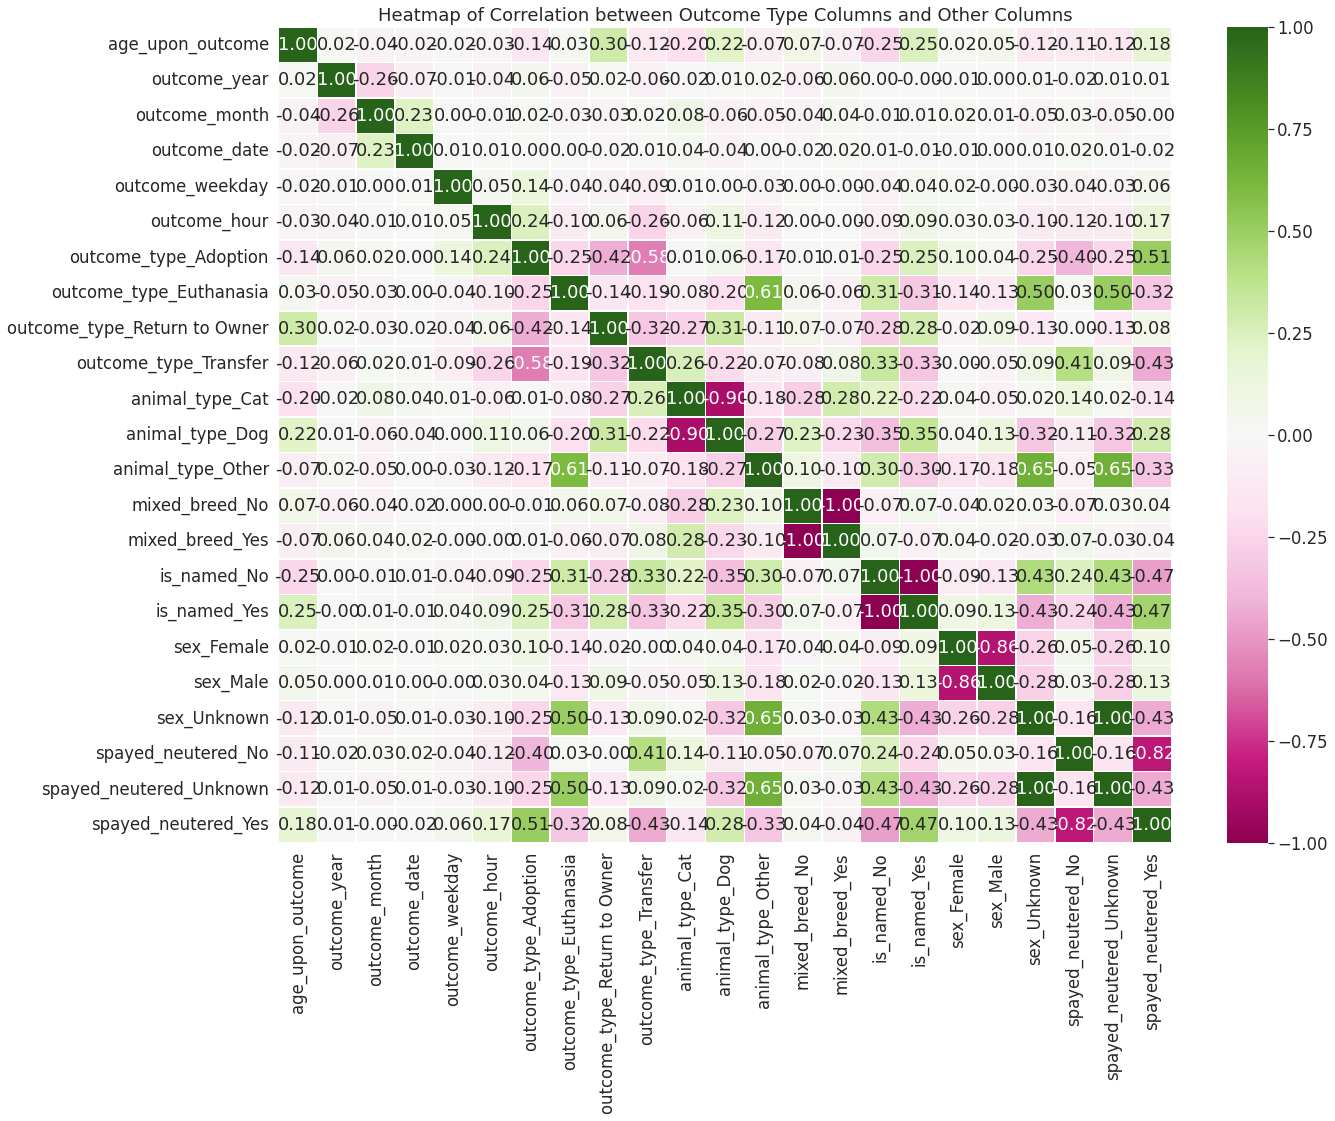

In [283]:
# Computing the correlation matrix
dtf_corr = dtf_encoded.corr(method="pearson")

# Plotting the heatmap
plt.subplots(figsize=(20,15))
sns.heatmap(dtf_corr, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap="PiYG", cbar=True, linewidths=0.5)
plt.title('Heatmap of Correlation between Outcome Type Columns and Other Columns')
plt.show()

We can see that columns like <font color='#012f85'><b>'outcome_date'</b></font>, <font color='#012f85'><b>'outcome_month'</b></font> and <font color='#012f85'><b>'outcome_year'</b></font> have little impact on the target features (<font color='#089ffc'><b>'outcome_type_Adoption/Euthanasia/Return to Owner/Transfer'</b></font>), and may not add new insights predicting it. They do have some correlations with each other though (respectively). For instance, there is a correlation of -0.26 between 'outcome_year' and 'outcome_month' (which does makes sense).

-----------------add more comments.

#### <b>Comparing to 'outcome_subtype' column:</b>

In [281]:
# Defining columns to encode
columns_to_encode = ['outcome_type', 'outcome_subtype']

# Encoding columns using one-hot encoding
dtf_encoded_outcome = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

# Defining outcome type columns and outcome subtype columns
outcome_type_columns = [col for col in dtf_encoded_outcome.columns if 'outcome_type' in col]
outcome_subtype_columns = [col for col in dtf_encoded_outcome.columns if 'outcome_subtype' in col]

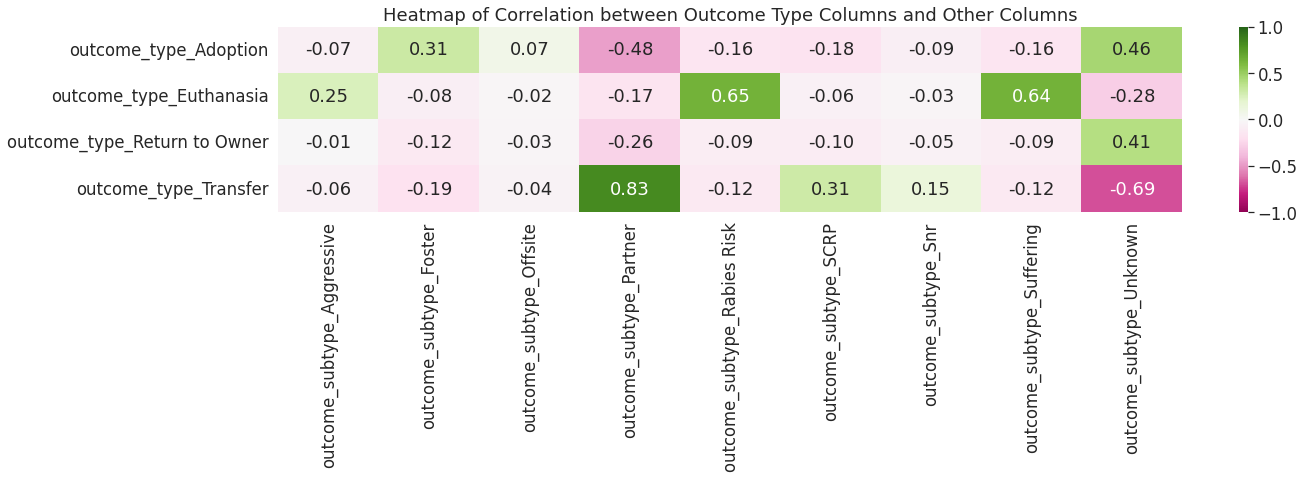

In [282]:
# Computing the correlation matrix
dtf_corr = dtf_encoded_outcome[outcome_type_columns + outcome_subtype_columns].corr(method="pearson")

# Plotting the heatmap
plt.subplots(figsize=(20, 7))
sns.heatmap(dtf_corr.loc[outcome_type_columns, outcome_subtype_columns], vmin=-1, vmax=1, annot=True,
        cmap='PiYG', fmt=".2f")
plt.title('Heatmap of Correlation between Outcome Type Columns and Other Columns')
plt.tight_layout()
plt.show()

There is a strong association between <font color='#012f85'><b>'outcome_subtype_Partner'</b></font> and <font color='#089ffc'><b>'outcome_type_Transfer'</b></font>, evidenced by a correlation coefficient of <font color='#015714'><b>0.83</b></font>. This suggests that many instances with the outcome type of transfer, predominantly involving cats, have an outcome subtype of partner, indicating a transfer to a partnering shelter. Also, animals associated with <font color='#012f85'><b>'outcome_subtype_Partner'</b></font> are less likely to get adopted, as indicated by a correlation of <font color='#de0492'><b>-0.48</b></font> with <font color='#089ffc'><b>'outcome_type_Adoption'</b></font>.

Additionally, animals identified with <font color='#012f85'><b>'outcome_subtype_Rabies Risk'</b></font> or <font color='#012f85'><b>'outcome_subtype_Suffering'</b></font> demonstrate a higher likelihood of euthanasia, with correlation coefficients of <font color='#015714'><b>0.65</b></font> and <font color='#015714'><b>0.64</b></font>, respectively, with <font color='#089ffc'><b>'outcome_type_Euthanasia'</b></font>.

Moreover, animals categorized with <font color='#012f85'><b>'outcome_subtype_Unknown'</b></font> are less inclined to be transferred (correlation of <font color='#de0492'><b>-0.69</b></font> with <font color='#089ffc'><b>'outcome_type_Transfer'</b></font>) or euthanized (correlation of <font color='#de0492'><b>-0.28</b></font> with <font color='#089ffc'><b>'outcome_type_Euthanasia'</b></font>). Instead, they show potential for being returned to their owners (correlation of <font color='#015714'><b>0.41</b></font> with <font color='#089ffc'><b>'outcome_type_Return to Owner'</b></font>) or adopted (correlation of <font color='#015714'><b>0.46</b></font> with <font color='#089ffc'><b>'outcome_type_Adoption'</b></font>).

***

## <b>Basic ML Model</b>

### <b>Training the model and predicting</b>

In [284]:
# Dropping 'animal_id' column from the dataframe
dtf_model = df.drop('animal_id', axis=1)

# Converting all columns to the category data type
dtf_model = dtf_model.astype('category')

In [285]:
# Columns for one-hot encoding
columns_for_one_hot = ['animal_type', 'breed', 'mixed_breed', 'color1', 'color2', 'is_named', 'outcome_subtype',
                    'outcome_type', 'sex', 'spayed_neutered']

# One-hot encoding
encoded_data = pd.get_dummies(dtf_model[columns_for_one_hot])

# Getting all the target columns (columns that include 'outcome_type' in their name)
outcome_type_columns = [col for col in encoded_data.columns if 'outcome_type' in col]

In [286]:
# Initialize StandardScaler object for feature scaling
scaler = StandardScaler()

# Initialize lists to store scores
validation_scores = []
test_scores = []

# Initialize an empty dictionaries to store feature importances and shap values
feature_importances = {}
shap_values = {}

<font color='#f542b0'>---------------takes 2 minutes. Add a skip option.</font>

In [287]:
for outcome_column in outcome_type_columns:
    # Prepare the data
    X = encoded_data.drop(outcome_type_columns, axis=1)
    y = encoded_data[outcome_column]

    # Initialize the model
    model = XGBClassifier(objective='binary:logistic', eval_metric='error', random_state=42)

    validation_scores, test_scores, model, feature_importances = fit_and_predict(outcome_column,
                            X, y, validation_scores, test_scores, model, feature_importances, scaler)
    
    # Explain model predictions using SHAP
    explainer = shap.TreeExplainer(model)
    shap_values[outcome_column] = explainer.shap_values(X)

Column 'outcome_type_Adoption':
Validation scores:
Accuracy: 0.84191, Precision: 0.84545, Recall: 0.85173, F1-score: 0.84153

Test scores:
Accuracy: 0.84115, Precision: 0.84552, Recall: 0.84999, F1-score: 0.84095

Column 'outcome_type_Euthanasia':
Validation scores:
Accuracy: 0.99614, Precision: 0.98312, Recall: 0.98944, F1-score: 0.98625

Test scores:
Accuracy: 0.99697, Precision: 0.98374, Recall: 0.99391, F1-score: 0.98877

Column 'outcome_type_Return to Owner':
Validation scores:
Accuracy: 0.84962, Precision: 0.79100, Recall: 0.64223, F1-score: 0.67442

Test scores:
Accuracy: 0.84741, Precision: 0.78634, Recall: 0.64454, F1-score: 0.67617

Column 'outcome_type_Transfer':
Validation scores:
Accuracy: 0.98059, Precision: 0.97359, Recall: 0.98160, F1-score: 0.97746

Test scores:
Accuracy: 0.97889, Precision: 0.97045, Recall: 0.98042, F1-score: 0.97523



<b>Evaluating the performance of the classification model according to the metrics above:</b>
1. <font color='#0837a3'><b>Accuracy:</b></font><br>
This represents the proportion of correctly classified instances out of the total instances. For example, an accuracy score of 0.84 for the 'Adoption' outcome type means that the model correctly predicted 84% of the outcomes in the test dataset.
2. <font color='#0837a3'><b>Precision:</b></font><br>
Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. In the context of animal shelter outcomes, precision measures the accuracy of positive predictions. For instance, a precision score of 0.843 for the 'Adoption' outcome type means that when the model predicts an animal will be adopted, it is correct 84.3% of the time.
3. <font color='#0837a3'><b>Recall:</b></font><br>
Recall calculates the ratio of correctly predicted positive observations to the all observations in actual class. In the context of animal shelter outcomes, recall measures the ability of the model to correctly identify positive instances (e.g., correctly identifying animals that were actually adopted). A recall score of 0.848 for the 'Adoption' outcome type indicates that the model correctly identified 84.8% of the animals that were actually adopted.
4. <font color='#0837a3'><b>F1-score:</b></font><br>
The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall, especially when the classes are imbalanced. A higher F1-score indicates better model performance. For example, an F1-score of 0.84 for the 'Adoption' outcome type suggests a good balance between precision and recall for predicting adoptions.

<br>
<b>The precision, recall, and F1-score for the <font color='#f542b0'>'Return to Owner'</font> outcome type are slightly lower compared to the other outcome types. Here's a bit more insight into why this might be the case:</b>

1. <font color='#0837a3'><b>Precision (0.79766):</b></font><br>
A lower precision means that when the model predicts an animal will be returned to its owner, it's less likely to be correct. In this case, the precision for 'Return to Owner' is lower, indicating that the model might be incorrectly predicting some instances as 'Return to Owner' when they actually belong to other categories.
2. <font color='#0837a3'><b>Recall (0.64326):</b></font><br>
A lower recall means that the model is missing some instances of 'Return to Owner' in its predictions. This could be due to the complexity of the features associated with 'Return to Owner', making it harder for the model to correctly identify them.
3. <font color='#0837a3'><b>F1-score (0.67588):</b></font><br>
A lower F1-score suggests that there's a trade-off between precision and recall, indicating that the model is struggling to achieve both high precision and high recall simultaneously.

Possible reasons for these lower scores could include imbalanced data distribution, insufficient feature representation for 'Return to Owner', or inherent complexity in predicting this outcome type accurately.
<br>

<br>

### <b>Evaluating the model</b>

In [288]:
# Calculate average validation accuracy, precision, recall and f1-score
print_average_score('Validation', calculate_average_score(validation_scores))

# Calculate average test accuracy, precision, recall and f1-score
print_average_score('Test', calculate_average_score(test_scores))

Average Validation Scores:
Accuracy: 0.91707
Precision: 0.89829
Recall: 0.86625
F1-score: 0.86992

Average Test Scores:
Accuracy: 0.91610
Precision: 0.89651
Recall: 0.86722
F1-score: 0.87028



The average validation scores and the average test scores indicate the model's performance in predicting the target variable, 'outcome_type'. The validation accuracy stands at 91.7%, while the test accuracy is slightly lower at 91.62%. Additionally, the precision, recall, and F1-score metrics provide insights into the model's ability to correctly classify the outcomes. With precision, recall, and F1-score averaging around 89.9%, 86.6%, and 86.8% respectively, the model demonstrates a balanced performance across various evaluation metrics.

In [289]:
# Define the number of top features to display
top_n_features = 15

# Calculate average feature importances across all outcome types
avg_feature_importances = np.mean([importances for importances in feature_importances.values()], axis=0)

# Sort and get the indices of top N most important features
top_feature_indices = avg_feature_importances.argsort()[-top_n_features:][::-1]

# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'importance': avg_feature_importances[top_feature_indices],
                               'feature': np.array(encoded_data.columns)[top_feature_indices]})

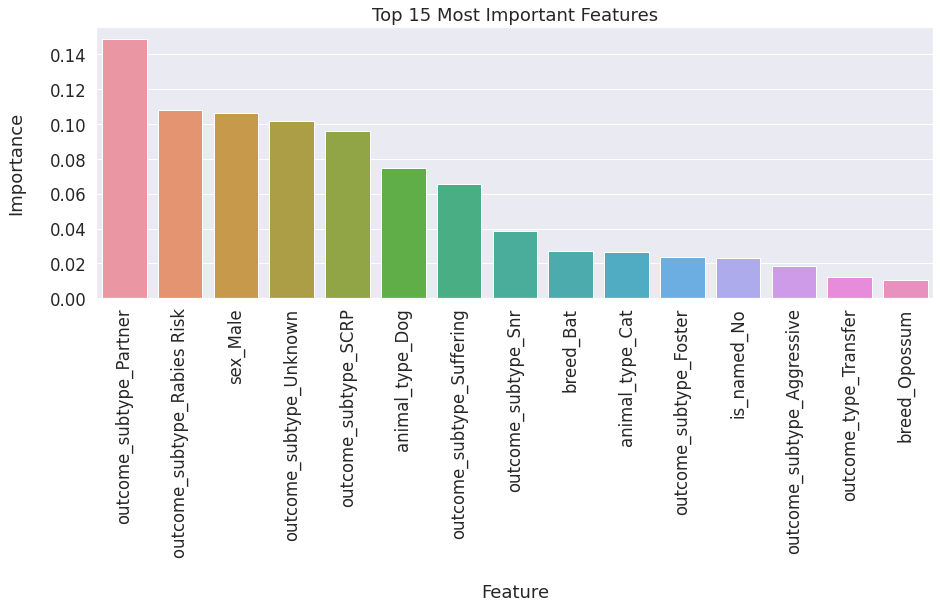

In [290]:
# Set seaborn font scale
sns.set(font_scale=1.50)

# Create a bar plot of top N most important features
plt.figure(figsize=(15, 5))
sns.barplot(x='feature', y='importance', data=importances_df)
plt.xticks(rotation=90)
plt.xlabel('Feature', labelpad=25)
plt.ylabel('Importance', labelpad=25)
plt.title(f'Top {top_n_features} Most Important Features')
plt.show()

<b>The XGB classifier identifies several key features crucial for predicting the outcome of an animal (<font color='#089ffc'>adoption, transfer, return to owner, or euthanasia</font>):</b>

* The most influential feature is the outcome subtype of the animal 'outcome_subtype_Partner', indicating that the animal was transfered to a partnering shelter.

* The sex of the animal, particularly if male ('sex_Male'), contributes to prediction.

* Unknown outcome subtype ('outcome_subtype_Unknown'), SCRP outcome subtype ('outcome_subtype_SCRP'), rabies risk outcome subtype ('outcome_subtype_Rabies Risk') and suffering outcome subtype ('outcome_subtype_suffering') all contribute to prediction.

* The classifier gives weight to the animal type, especially if it's a dog ('animal_type_Dog').

* SNR outcome subtype ('outcome_subtype_SNR') contributes to prediction.

* Bat breed, classified under 'Other' types, contributes to the prediction ('breed_Bat').

* The classifier gives weight to the animal type, especially if it's a cat ('animal_type_Cat').

* The classifier gives weight if an animal is named, especially if the animal is unnamed ('is_named_No').

* Outcome subtypes associated with fostering, often seen in cats ('outcome_subtype_Foster'), impact predictions.

* Outcome subtypes associated with aggression, often seen in dogs ('outcome_subtype_Aggressive'), impact predictions.

* Opossum breed, classified under 'Other' types, contributes to the prediction ('breed_Opossum').

* Raccoon breed, classified under 'Other' types, contributes to the prediction ('breed_Raccoon').


Column 'outcome_type_Adoption':


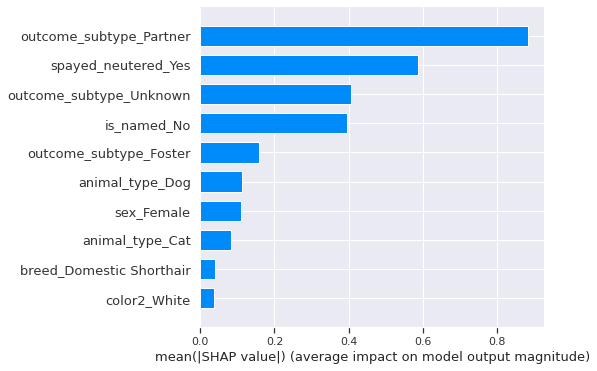



Column 'outcome_type_Euthanasia':


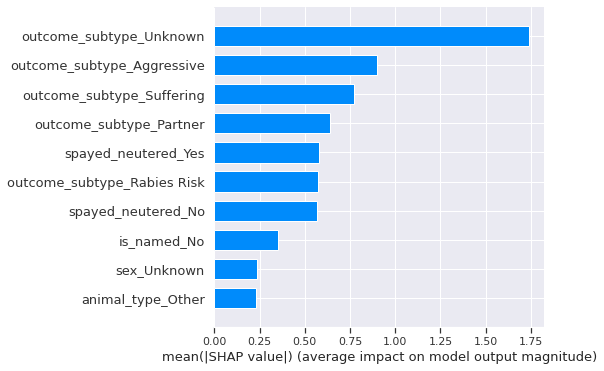



Column 'outcome_type_Return to Owner':


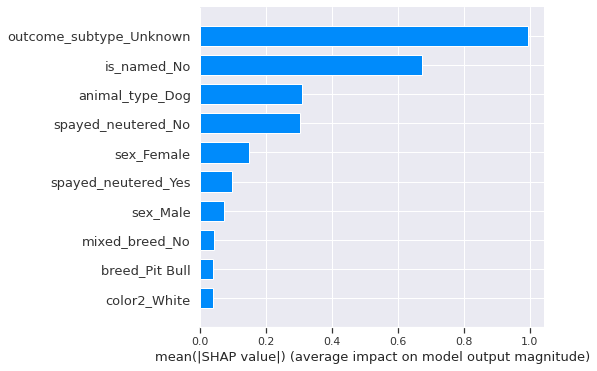



Column 'outcome_type_Transfer':


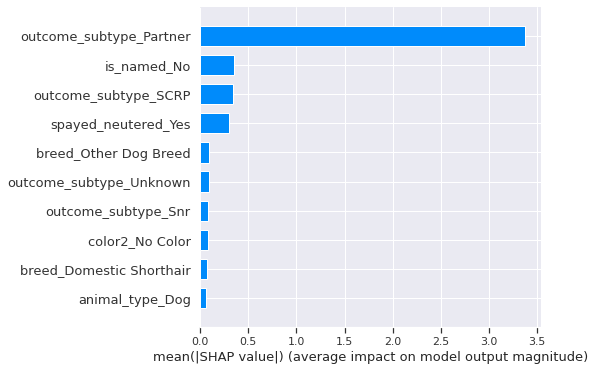

In [291]:
# Plot SHAP summary plot for each outcome column
for outcome_column in outcome_type_columns:
    # Get SHAP values for the outcome column
    shap_values_outcome = shap_values[outcome_column]

    print(f"\n\033[1mColumn '{outcome_column}':\033[0m")
    
    # Plot SHAP summary plot
    shap.summary_plot(shap_values_outcome, X, plot_type="bar", max_display=10,
                            title=outcome_column)
    
    print()